Predicting Home Prices in Ames, Iowa
---
The goal of this project is to determine the best algorithms and approaches for predicting home prices in Ames, Iowa based on a data set taken from Kaggle.com. The train.csv file has house prices, and the test.csv file does not, so the actual internal calibration of the model (including training and test splits) must be done using the train.csv file only. The test.csv file is for the competition submission.

For my first pass at this exercise, I'm going to focus on applying linear regression (and perhaps non-linear) using as few variables as I can get away with. I will try to convert categorical variables to numeric variables that have some sense of order (e.g., quality) and I will leave behind the rest. Note that I would like to return to this in the future and explore other statistical methods such as decision trees, clustering, etc.

For more detailed descriptions of the variables and what they represent, please see the accompanying data_description.txt file.

**Setup and Data Load** 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

prices = pd.read_csv("train.csv")

print("Data Set")
print("Rows: {0}, Columns: {1}".format(prices.shape[0],prices.shape[1]))

Data Set
Rows: 1460, Columns: 81


**Data Investigation - Numeric Columns** 

In [2]:
cols = list(prices.columns)

col_num = []
typ_num = []
min_num = []
max_num = []
avg_num = []
nan_num = []

for col in cols:
    if ((prices[col].dtype == "int64") | (prices[col].dtype == "float64")) & (col != "Id"):
        col_num.append(col)
        typ_num.append(prices[col].dtype)
        min_num.append(prices[col].min())
        max_num.append(prices[col].max())
        avg_num.append(prices[col].mean())
        nan_num.append(100*len(prices[col].loc[pd.isnull(prices[col])]) / len(prices[col]))

numeric = {'col':col_num,'type':typ_num,'min':min_num, 'max':max_num, 'avg':avg_num, 'nan%':nan_num}
numeric_summary = pd.DataFrame(numeric)
numeric_summary = numeric_summary[['col','type','min','avg','max','nan%']]
numeric_summary

,col,type,min,avg,max,nan%
0,MSSubClass,int64,20.0,56.897260,190.0,0.000000
1,LotFrontage,float64,21.0,70.049958,313.0,17.739726
2,LotArea,int64,1300.0,10516.828082,215245.0,0.000000
3,OverallQual,int64,1.0,6.099315,10.0,0.000000
4,OverallCond,int64,1.0,5.575342,9.0,0.000000
5,YearBuilt,int64,1872.0,1971.267808,2010.0,0.000000
6,YearRemodAdd,int64,1950.0,1984.865753,2010.0,0.000000
7,MasVnrArea,float64,0.0,103.685262,1600.0,0.547945
8,BsmtFinSF1,int64,0.0,443.639726,5644.0,0.000000
9,BsmtFinSF2,int64,0.0,46.549315,1474.0,0.000000


In [3]:
misc_to_sale = prices['MiscVal'] / prices['SalePrice']
tot_misc_cts = len(prices.loc[prices['MiscVal']> 0])
tot_above_1per = len(misc_to_sale[misc_to_sale > 0.01])

print("MiscVal Stats","\n")
print("Number of rows where MiscVal > 0: {0}".format(tot_misc_cts))
print("Mean ratio of MiscVal to SalePrice: {0}".format(misc_to_sale.mean()))
print("Max ratio of MiscVal to SalePrice: {0}".format(misc_to_sale.max()))
print("Number of rows where ratio of MiscVal to SalePrice > 0.01: {0}".format(tot_above_1per))

num_pools = len(prices.loc[prices['PoolArea'] > 0])
print("\n")
print("PoolArea Stats","\n")
print("Number of rows where PoolArea > 0: {0}".format(num_pools))

MiscVal Stats 

Number of rows where MiscVal > 0: 52
Mean ratio of MiscVal to SalePrice: 0.00030859857576703614
Max ratio of MiscVal to SalePrice: 0.10231023102310231
Number of rows where ratio of MiscVal to SalePrice > 0.01: 6


PoolArea Stats 

Number of rows where PoolArea > 0: 7


**Discussion:** For this exercise, I'll want to reduce the list of variables so that I can focus on the appropriate QC and modelling, rather than simply mining for correlations. The more variables you have, the more likely you are to find spurious correlations due to chance rather than reality. Therefore, I want to eliminate some variables, and I want to combine others. One important choice I need to make is whether to focus on numbers of features (rooms, etc.) or sizes of features (square footage). Although individual rooms vary in size, the number of rooms will strongly correlate to the total square footage. Ratios, to get average room size, may be valuable. In addition, I'll want to eliminate variables where most of the rows have the same value. For example, the MiscVal and PoolArea columns only have a handful of rows with significant values. Conceptually, pools and additions impact housing prices, but because so few houses have these features in this data set, our models will not be well trained on those variables. Finally, I'll want to remove any numeric variables where the values are *not* actually representative of a linear sequence. The only variable that fits that description is month sold (MoSold). Even though values range from 1-12, they don't give us a good scale to work with. December and January are right next to each other, but they have values of 12 and 1, respectively. Because the scale wraps around, trends are typically cyclical rather than linear. Although it is possible to use the monthly data as a categorical value, I'm going to discard it for this first-pass through the data. It may be worth investigating in the future, however.

**Numeric Variables To Keep (and Their Transformations):**
* LotArea
* OverallQual
* OverallCond
* YearBuilt
* YearRemod = YearRemodAdd - YearBuilt
* Baths = FullBath + (0.5 x HalfBath) + BsmtFullBath + (0.5 x BsmtHalfBath)
* Bedrooms = BedroomAbvGr
* Kitchens = KitchenAbvGr
* Fireplaces
* AveRmArea = GrLivArea / TotRmsAbvGrd
* BsmtArea = TotalBsmtSF
* GarageArea
* PorchArea = WoodDeckSF + OpenPorchSF + EnclosedPorch + 3SsnPorch + ScreenPorch
* YrSold
* SalePrice

**Data Investigation - Object Columns**

In [4]:
col_obj = []
unq_obj = []
mfreq = []
mfreq_cts = []
sfreq = []
sfreq_cts = []
mfreq_fract = []
cts_obj = []

for col in cols:
    if (prices[col].dtype == "object"):
        col_obj.append(col)
        cts = prices[col].value_counts(dropna=False)
        cts = cts.sort_values(ascending=False)
        
        most_freq = list(cts.iloc[[0]].index)[0]
        most_freq_cts = cts.iloc[0]
        sec_freq = list(cts.iloc[[1]].index)[0]
        sec_freq_cts = cts.iloc[1]
        
        mfreq.append(most_freq)
        mfreq_cts.append(most_freq_cts)
        sfreq.append(sec_freq)
        sfreq_cts.append(sec_freq_cts)
        mfreq_fract.append(most_freq_cts/float(len(prices)))
        cts_dict = cts.to_dict()
        unq_obj.append(len(cts_dict))
        cts_obj.append(cts_dict)

objects = {'col':col_obj,'unq':unq_obj,'mfreq':mfreq,'mfreq_cts':mfreq_cts,\
           'sfreq':sfreq,'sfreq_cts':sfreq_cts,'mfreq_fract':mfreq_fract,'cts':cts_obj}
object_summary = pd.DataFrame(objects)
object_summary = object_summary[['col','unq','mfreq','mfreq_cts','sfreq','sfreq_cts','mfreq_fract','cts']]
object_summary = object_summary.sort_values('mfreq_fract',ascending=False)
object_summary

,col,unq,mfreq,mfreq_cts,sfreq,sfreq_cts,mfreq_fract,cts
5,Utilities,2,AllPub,1459,NoSeWa,1,0.999315,"{'AllPub': 1459, 'NoSeWa': 1}"
1,Street,2,Pave,1454,Grvl,6,0.995890,"{'Pave': 1454, 'Grvl': 6}"
38,PoolQC,4,NaN,1453,Gd,3,0.995205,"{nan: 1453, 'Gd': 3, 'Fa': 2, 'Ex': 2}"
10,Condition2,8,Norm,1445,Feedr,6,0.989726,"{'PosA': 1, 'RRAe': 1, 'Norm': 1445, 'Artery':..."
14,RoofMatl,8,CompShg,1434,Tar&Grv,11,0.982192,"{'WdShngl': 6, 'Roll': 1, 'Tar&Grv': 11, 'ClyT..."
26,Heating,6,GasA,1428,GasW,18,0.978082,"{'Wall': 4, 'GasW': 18, 'OthW': 2, 'Floor': 1,..."
40,MiscFeature,5,NaN,1406,Shed,49,0.963014,"{nan: 1406, 'TenC': 1, 'Gar2': 2, 'Othr': 2, '..."
7,LandSlope,3,Gtl,1382,Mod,65,0.946575,"{'Mod': 65, 'Sev': 13, 'Gtl': 1382}"
2,Alley,3,NaN,1369,Grvl,50,0.937671,"{nan: 1369, 'Grvl': 50, 'Pave': 41}"
28,CentralAir,2,Y,1365,N,95,0.934932,"{'N': 95, 'Y': 1365}"


In [5]:
bldg = object_summary['cts'].loc[object_summary['col'] == 'BldgType'].values[0]
house = object_summary['cts'].loc[object_summary['col'] == 'HouseStyle'].values[0]
lot = object_summary['cts'].loc[object_summary['col'] == 'LotConfig'].values[0]

print("BldgType")
print(bldg,"\n")
print("HouseStyle")
print(house,"\n")
print("LotConfig")
print(lot,"\n")

BldgType
{'1Fam': 1220, '2fmCon': 31, 'Twnhs': 43, 'TwnhsE': 114, 'Duplex': 52} 

HouseStyle
{'SLvl': 65, '2.5Unf': 11, '2.5Fin': 8, '1.5Fin': 154, '1.5Unf': 14, 'SFoyer': 37, '1Story': 726, '2Story': 445} 

LotConfig
{'CulDSac': 94, 'FR3': 4, 'FR2': 47, 'Corner': 263, 'Inside': 1052} 



**Discussion:** Because I want to focus on regression techniques, I want numeric variables and I want variables to have reasonable distributions. In addition, I want variables to be largely independent to avoid over-weighting certain information. If you look at the object-type variables above, you can see that a single categorical value dominates in the majority of instances. Such a biased distribution is generally bad for regression. Therefore, we can immediately conclude that we'd like to discard every variable where the top value represents, say, more than 75% of the observations (just an arbitrary cutoff). The exception is BldgType, which may come in handy later. Many of the other variables are quality indicators, but the overall quality of the property is present as a numeric aggregate. If the qualities of the individual house components have disproportionate impacts on the price, then leaving them out could reduce the accuracy of the predictions. For now, though, let's see how accurate we can get using the aggregate quality. Finally, a number of the variables are descriptions of roofing, siding, etc. which would be difficult to convert to value scales. Therefore, we'll ignore them.

**Object Variables To Keep (and Their Conversions to Numeric Values):**
* Single = whether BldgType is '1Fam' [1] or not [0]
* Stories = HouseStyle converted [1, 1.5, 2, 2.5], where SLvl and SFoyer are set to 2
* CornerLot = 'Inside' + 'CulDSace' [0], 'FR2' + 'FR3' + 'Corner' [1]
* Neighborhood = convert to dummy variables (0,1 pairs)

**Creating the Reduced and Transformed Data Set**

In [6]:
def convert_df(df, type):
    # Cleaning up NaN
    df['BsmtFullBath'] = df['BsmtFullBath'].fillna(0)
    df['BsmtHalfBath'] = df['BsmtHalfBath'].fillna(0)
    df['TotalBsmtSF'] = df['TotalBsmtSF'].fillna(0)
    df['GarageArea'] = df['GarageArea'].fillna(0)
    
    # Building new transformed dataframe
    df_num = pd.DataFrame()
    if (type == "train"):
        df_num['SalePrice'] = df['SalePrice']
    df_num['LotArea'] = df['LotArea']
    df_num['OverallQual'] = df['OverallQual']
    df_num['OverallCond'] = df['OverallCond']
    df_num['YearBuilt'] = df['YearBuilt']
    df_num['YearRemod'] = df['YearRemodAdd'] - df['YearBuilt'] 
    df_num['Baths'] = df['FullBath'] + 0.5*df['HalfBath'] + df['BsmtFullBath'] + 0.5*df['BsmtHalfBath']
    df_num['Bedrooms'] = df['BedroomAbvGr']
    df_num['Kitchens'] = df['KitchenAbvGr']
    df_num['Fireplaces'] = df['Fireplaces']
    df_num['AveRmArea'] = df['GrLivArea'] / df['TotRmsAbvGrd']
    df_num['BsmtArea'] = df['TotalBsmtSF']
    df_num['GarageArea'] = df['GarageArea']
    df_num['PorchArea'] = df['WoodDeckSF'] + df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch']
    df_num['YrSold'] = df['YrSold']
    
    single_conv = {'1Fam': 1, 'Twnhs': 0, 'Duplex': 0, '2fmCon': 0, 'TwnhsE': 0} 
    story_conv = {'2.5Unf': 2.5, '2Story': 2, '2.5Fin': 2.5, '1.5Fin': 1.5, '1Story': 1, '1.5Unf': 1.5, 'SLvl': 2, 'SFoyer': 2}
    corner_conv = {'FR2': 1, 'FR3': 1, 'CulDSac': 0, 'Corner': 1, 'Inside': 0} 
    df_num['Single'] = df['BldgType'].apply(lambda x: single_conv[x])
    df_num['Stories'] = df['HouseStyle'].apply(lambda x: story_conv[x])
    df_num['CornerLot'] = df['LotConfig'].apply(lambda x: corner_conv[x])

    # Convert neighborhoods to dummy variables, only add n-1 to dataframe
    nb = pd.get_dummies(df['Neighborhood'],prefix="in",prefix_sep='_')
    nb_cols = len(nb.columns)
    nb = nb.iloc[:,0:nb_cols-1]
    nb_cols = list(nb.columns)
    df_num = pd.concat([df_num,nb],axis=1)

    return df_num, nb_cols

prices_num, nb_cols = convert_df(prices,"train")
prices_num

,SalePrice,LotArea,OverallQual,OverallCond,YearBuilt,YearRemod,Baths,Bedrooms,Kitchens,Fireplaces,...,in_NWAmes,in_NoRidge,in_NridgHt,in_OldTown,in_SWISU,in_Sawyer,in_SawyerW,in_Somerst,in_StoneBr,in_Timber
0,208500,8450,7,5,2003,0,3.5,3,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,181500,9600,6,8,1976,0,2.5,3,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,223500,11250,7,5,2001,1,3.5,3,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,140000,9550,7,5,1915,55,2.0,3,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,250000,14260,8,5,2000,0,3.5,4,1,1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,143000,14115,5,5,1993,2,2.5,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,307000,10084,8,5,2004,1,3.0,3,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7,200000,10382,7,6,1973,0,3.5,3,1,2,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,129900,6120,7,5,1931,19,2.0,2,2,2,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9,118000,7420,5,6,1939,11,2.0,2,2,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Discussion:** We now have 41 variables to use for our regression models. If we had taken the original 80 columns and converted each categorical variable to a set of dummies, our total number of parameters would be well over 100. Therefore, we've significantly shrunk the problem. However, ultimately, the most robust model will be the one that gives us good predictive capabilities for the fewest parameters. The reason is that there are more sample points in the planes we're fitting when we reduce the dimensions. Our next task is to try building the complexity of our model by seeing which features have the largest impact on performance. Initially, we'll test our models on the full data set. Then, once we've selected our best set of features, we'll perform cross-validation to ensure that the models remain robust in the face of sub-sampling.

**Choosing Our Error Terms**

In [7]:
def reg_error(estimator, X, y):
    estimator.fit(X,y)
    y_hat = estimator.predict(X)
    errors = abs(y - y_hat)
    rmse = (sum(errors**2)/float(len(errors)))**(1/2)
    lt_10k = 0
    for error in errors:
        if error < 10000:
            lt_10k += 1
    lt_10k = lt_10k / float(len(errors))
    return [rmse, lt_10k]

**Discussion:** I've chosen to go with two error terms in this project. The first is the standard root mean squared error (RMSE). RMSE is good at weighting significant outliers, so it will help us identify when we're getting some major prediction mistakes. On the other hand, we'll want to know how well our model does on a typical house. If we get 95% of our predictions within a few dollars, and 5% have errors in the \$100k range, we can't see that with just RMSE. Mean absolute error can help, but the mean is too heavily influenced by the outliers. For this exercise, I'm going to use a custom error metric. I want to know what percent of the time our estimate is within \$10k of the actual price. I could alternatively use a percent threshold, but an absolute threshold is less prone to artificially high errors at the low price end (a house sells for \$10k, we guess close at \$9k but the error is 10%) and artificially low errors at the high price end (a house sells for \$1 million, we guess \$900k, the error is still 10%).

**Baseline Error Estimates Without a Model**

In [8]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

mean_price = prices_num['SalePrice'].mean()
errors_noreg = abs(prices_num['SalePrice'] - mean_price)
rmse_noreg = (sum(errors_noreg**2)/float(len(errors_noreg)))**(1/2)
lt_10k_noreg = len(errors_noreg.loc[errors_noreg < 10000])/float(len(errors_noreg))
print("Mean Price: {0}".format(mean_price))
print("RMSE, No Regression: {0}".format(rmse_noreg))
print("Percent Esimates Within $10k: {0}".format(lt_10k_noreg))

Mean Price: 180921.19589041095
RMSE, No Regression: 79415.29188606751
Percent Esimates Within $10k: 0.1267123287671233


**Discussion:** If we didn't try to model the data and we only used the average price as our guess, our root mean squared error would be ~\$79k. We'd be within \$10k of the price ~13% of the time, though, which indicates there are a lot of houses sitting close to that mean value.

**Visual Inspection of Selected Relationships**

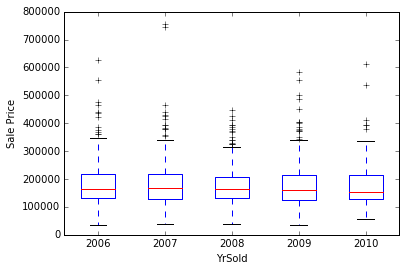

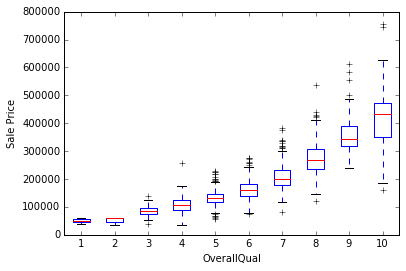

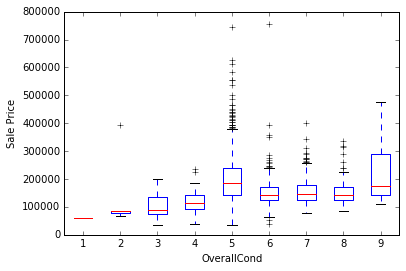

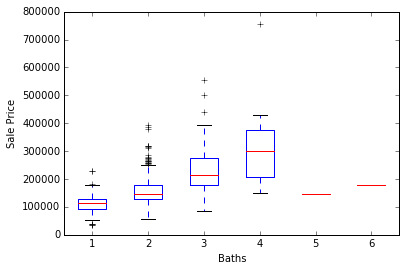

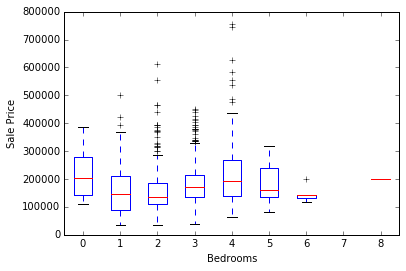

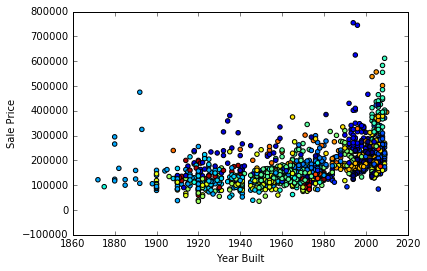

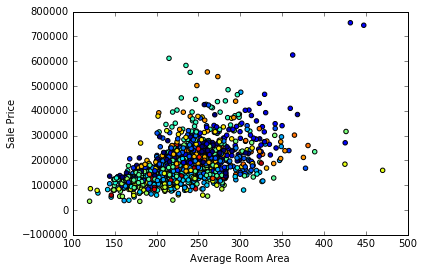

In [9]:
def create_box_plot(col):
    step = 1
    maxVal = int(prices_num[col].max())
    minVal = int(prices_num[col].min())
    vals = [x for x in range(minVal,maxVal+1,step)]
    vals_for_box = []
    for v in vals:
        val_set = prices_num['SalePrice'].loc[prices_num[col] == v]
        vals_for_box.append(val_set)
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.boxplot(vals_for_box)
    ax.set_xticklabels(vals)
    if len(vals) > 10:
        show_step = int(round(len(vals)/10,0))
        for i,label in enumerate(ax.xaxis.get_ticklabels()):
            if (i%show_step == 0):
                label.set_visible(True)
            else:
                label.set_visible(False)
    ax.set_xlabel(col)
    ax.set_ylabel("Sale Price")
    plt.show()

create_box_plot('YrSold')
create_box_plot('OverallQual')
create_box_plot('OverallCond')
create_box_plot('Baths')
create_box_plot('Bedrooms')

nb_orig = prices['Neighborhood']
nb_names = nb_orig.unique()
nb_dict = {}
for i,name in enumerate(nb_names):
    nb_dict[name] = i
nb_codes = nb_orig.map(nb_dict)
    
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(prices_num['YearBuilt'],prices_num['SalePrice'],c=nb_codes)
ax.set_xlabel("Year Built")
ax.set_ylabel("Sale Price")
plt.show()

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(prices_num['AveRmArea'],prices_num['SalePrice'],c=nb_codes)
ax.set_xlabel("Average Room Area")
ax.set_ylabel("Sale Price")
plt.show()

**Discussion:** One of the biggest concerns when performing a multivariate regression is that not all relationships that exist are linear. In a multivariate case, simply looking at cross plots cannot tell you as much as you'd like, because what you observe on the y-axis is impacted by other variables out of the plane. Having said that, it's worth looking at cross plots anyway. Variables that have strong impacts on the outcome often show clear correlations despite confounding variables (which act as noise if they have far less importance). The key feature to look for is strong non-linearity. In the plots above, you can already get a sense that 'OveralQual' will be critical for prediction, and though the relationship doesn't *appear* fully linear, the impacts of non-linearity will be minor. On the other hand, 'YearBuilt' might have a non-linear relationship to price. We might be seeing the impact of another variable out of the plane, but the house prices rise dramatically for newer units. We can use our intuition and say that such a thing is quite likely to be real, based on the demand for new units in new developments.

**Looking More Closely at Year Built vs Price**

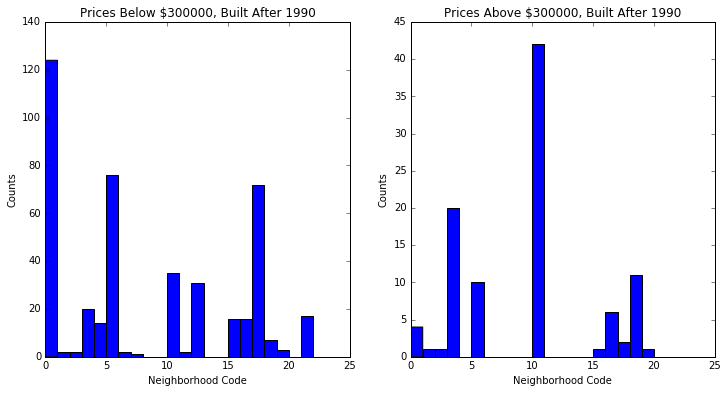

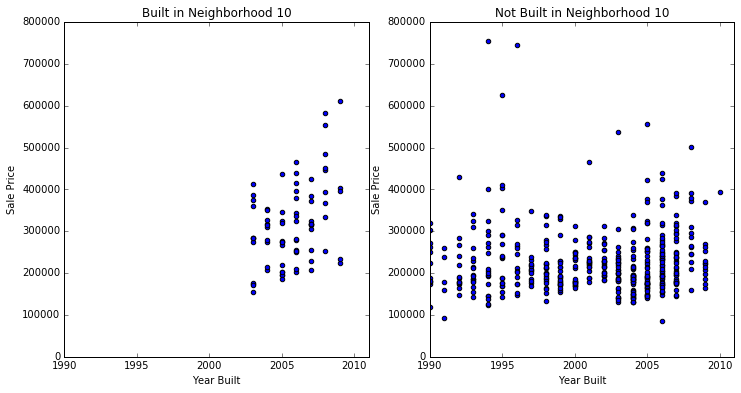

In [10]:
cutoff_price = 300000
cutoff_year = 1990
above_price = prices.loc[(prices_num['SalePrice']>cutoff_price)&(prices_num['YearBuilt']>cutoff_year)]
below_price = prices.loc[(prices_num['SalePrice']<=cutoff_price)&(prices_num['YearBuilt']>cutoff_year)]
nb_codes_above = above_price['Neighborhood'].map(nb_dict)
nb_codes_below = below_price['Neighborhood'].map(nb_dict)

bins = [x for x in range(0,26)]
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,2,1)
ax1.hist(nb_codes_below,bins=bins)
ax1.set_xlabel("Neighborhood Code")
ax1.set_title("Prices Below ${0}, Built After {1}".format(cutoff_price,cutoff_year))
ax1.set_ylabel("Counts")
ax2 = fig.add_subplot(1,2,2)
ax2.hist(nb_codes_above,bins=bins)
ax2.set_xlabel("Neighborhood Code")
ax2.set_title("Prices Above ${0}, Built After {1}".format(cutoff_price,cutoff_year))
ax2.set_ylabel("Counts")
plt.show()

nb_selected = 10
in_selected = prices_num.loc[nb_codes == nb_selected]
out_selected = prices_num.loc[nb_codes != nb_selected]
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,2,1)
ax1.scatter(in_selected['YearBuilt'],in_selected['SalePrice'])
ax1.set_xlim([cutoff_year,2011])
ax1.set_ylim([0,800000])
ax1.set_xlabel("Year Built")
ax1.set_title("Built in Neighborhood {0}".format(nb_selected))
ax1.set_ylabel("Sale Price")
ax2 = fig.add_subplot(1,2,2)
ax2.scatter(out_selected['YearBuilt'],out_selected['SalePrice'])
ax2.set_xlim([cutoff_year,2011])
ax2.set_ylim([0,800000])
ax2.set_xlabel("Year Built")
ax2.set_title("Not Built in Neighborhood {0}".format(nb_selected))
ax2.set_ylabel("Sale Price")
plt.show()

**Discussion:** The strong increase in sales price for newer houses appears to be related to *where* the houses were built as much as *when* they were built. New houses in most neighborhoods were being sold for prices that were comparable to ones built 10-20 years prior (within reason, obviously other factors impact price as well). However, a lot of new houses were being built in one particular neighborhood, and those houses fetched a much higher price on average. Thus, it appears that price by year built rises dramatically, but what we're really seeing is high-priced houses being added to a particular neighborhood in recent years. That means that if we are appropriately capturing the neighborhoods as a set of variables (which we are), we should be able to model the effects of both parameters.

**Linear Regression: Looking for the Impacts of Adding Features**

In [11]:
reg_cols = nb_cols.copy()
add_cols = ['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemod', 'Baths', \
            'Bedrooms', 'Kitchens', 'Fireplaces', 'AveRmArea', 'BsmtArea', 'GarageArea', \
            'PorchArea', 'YrSold', 'Single', 'Stories', 'CornerLot']

error_arr = []
error_arr.append(['NoParams',rmse_noreg,lt_10k_noreg])
X = prices_num[reg_cols]
y = prices_num['SalePrice']
errors = reg_error(lr, X, y)
error_arr.append(['Neighborhood',errors[0],errors[1]])

for col in add_cols:
    reg_cols.append(col)
    X = prices_num[reg_cols]
    y = prices_num['SalePrice']
    errors = reg_error(lr, X, y)
    error_arr.append([col,errors[0],errors[1]])

print('Additional Parameter Added       RMSE        Fraction Within $10k Of Actual')
for row in error_arr:
    print(row)

Additional Parameter Added       RMSE        Fraction Within $10k Of Actual
['NoParams', 79415.291886067513, 0.1267123287671233]
['Neighborhood', 53534.684652657517, 0.23972602739726026]
['LotArea', 51891.341156890616, 0.25068493150684934]
['OverallQual', 41084.990209801421, 0.28698630136986303]
['OverallCond', 41001.325715638734, 0.2773972602739726]
['YearBuilt', 40705.733286559545, 0.2808219178082192]
['YearRemod', 40487.009339619712, 0.3]
['Baths', 38166.361928909821, 0.3061643835616438]
['Bedrooms', 37918.530567803238, 0.3315068493150685]
['Kitchens', 37847.977152519874, 0.3226027397260274]
['Fireplaces', 37092.289331136468, 0.33835616438356164]
['AveRmArea', 36750.230209173336, 0.3410958904109589]
['BsmtArea', 35674.208569443785, 0.3452054794520548]
['GarageArea', 34859.985761084899, 0.3664383561643836]
['PorchArea', 34618.2559952273, 0.36575342465753424]
['YrSold', 34610.701709725661, 0.36232876712328765]
['Single', 33696.602896340606, 0.3589041095890411]
['Stories', 33693.890976

**Discussion:** I added parameters one-by-one to the regression to determine how the RMSE and 10k values change. You can see the best possible model includes all parameters, and you can see that some parameters make a larger impact than others. Let's sort the parameters by the amount that they reduce the RMSE and then re-run the calculations, adding them in order.

**Linear Regression: Sorting Features By Impact**

In [12]:
error_drops = []
for e in range(0,len(error_arr)):
    if e == 0:
        error_drops.append([error_arr[e][0],error_arr[e][1],error_arr[e][2],1000000])
    else:
        drop = error_arr[e-1][1] - error_arr[e][1]
        error_drops.append([error_arr[e][0],error_arr[e][1],error_arr[e][2],drop])
error_drops = sorted(error_drops, key=lambda x: x[3], reverse=True)

reg_cols = nb_cols.copy()
add_cols = [x[0] for x in error_drops]
add_cols = add_cols[2:]

error_arr = []
error_arr.append(['NoParams',rmse_noreg,lt_10k_noreg])
X = prices_num[reg_cols]
y = prices_num['SalePrice']
errors = reg_error(lr, X, y)
error_arr.append(['Neighborhood',errors[0],errors[1]])

for col in add_cols:
    reg_cols.append(col)
    X = prices_num[reg_cols]
    y = prices_num['SalePrice']
    errors = reg_error(lr, X, y)
    error_arr.append([col,errors[0],errors[1]])

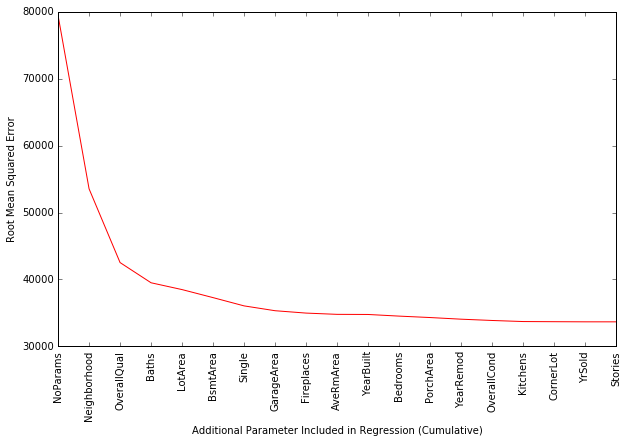

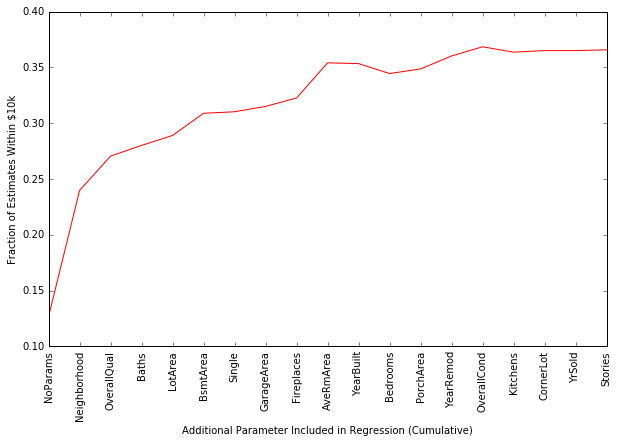

In [13]:
index_arr = [i for i,x in enumerate(error_arr)]
label_arr = [x[0] for x in error_arr]
rmse_arr = [x[1] for x in error_arr]
lt_10k_arr = [x[2] for x in error_arr]

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(index_arr,rmse_arr,color="red")
ax.set_xlabel("Additional Parameter Included in Regression (Cumulative)")
ax.set_ylabel("Root Mean Squared Error")
plt.xticks(index_arr, label_arr, rotation='vertical')
plt.show()

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(index_arr,lt_10k_arr,color="red")
ax.set_xlabel("Additional Parameter Included in Regression (Cumulative)")
ax.set_ylabel("Fraction of Estimates Within $10k")
plt.xticks(index_arr, label_arr, rotation='vertical')
plt.show()

**Discussion:** You can clearly see that the three most important features for our model are (1) the neighborhood, (2) the overall quality rating, and (3) the number of bathrooms. Nearly all of the drop in RMSE occurs with the addition of the first 9 or so features, and after that, little improvement occurs. The additional parameters still lead to some model tuning, because the number of estimates within \$10k increases gradually, but there is still little effective difference beyond the first ~9 features. There isn't likely any harm in using all of the features here, so we'll keep them.

**Checking to See if the Slopes Make Sense**

In [14]:
X = prices_num[reg_cols]
y = prices_num['SalePrice']
lr.fit(X,y)
coefs_full = lr.coef_

for i,coef in enumerate(coefs_full):
    print("Feature: {0}, Coefficient: {1}".format(reg_cols[i],coef))

Feature: in_Blmngtn, Coefficient: -3245.2642149993308
Feature: in_Blueste, Coefficient: -30293.69481723543
Feature: in_BrDale, Coefficient: -18330.726876606604
Feature: in_BrkSide, Coefficient: -18831.290776373615
Feature: in_ClearCr, Coefficient: -19673.601096134786
Feature: in_CollgCr, Coefficient: -25232.324978604578
Feature: in_Crawfor, Coefficient: 4516.174680812389
Feature: in_Edwards, Coefficient: -29579.074064521727
Feature: in_Gilbert, Coefficient: -30446.691353914328
Feature: in_IDOTRR, Coefficient: -27547.513493160717
Feature: in_MeadowV, Coefficient: -14024.337224865229
Feature: in_Mitchel, Coefficient: -32242.091829659363
Feature: in_NAmes, Coefficient: -28222.397288250242
Feature: in_NPkVill, Coefficient: -19270.990685055724
Feature: in_NWAmes, Coefficient: -38321.43107795096
Feature: in_NoRidge, Coefficient: 39168.838531810106
Feature: in_NridgHt, Coefficient: 39586.77771590647
Feature: in_OldTown, Coefficient: -31477.3896101893
Feature: in_SWISU, Coefficient: -29020.053

**Discussion:** It's always a good idea to sense-check the regression slopes and ask ourselves if they make sense. We may not know the magnitude of impact that a variable should have, but we should know our data well enough to guess (most of the time) the direction of influence. Most of the variables above relate to neighborhoods, so it would be prudent (in a real scenario) to look up the areas and see if the areas that correspond to higher prices in our model are "nicer" in a colloquial sense. For our other variables, we can evaluate them here.  According to the slopes above, higher quality houses, ones with more features (numbers of rooms, fireplaces, etc.), ones with larger features, ones with more stories, and ones that are detached single-family homes all should command higher prices. Those fit our expectations. Being on a corner hurts value, as expected, so we have another good sign that our model is working. Finally, the value appears to negatively correlate with the year that the house was sold. If we didn't have any knowledge of the time period in question, we may be skeptical of this result and look at it more closely, but the housing market collapsed in this timeframe, and we expect to see a negative trend. Overall, our coefficients look good and they agree with our understanding of the system. We always have to be careful not to let our ideas color our models too much, but at the end of the day, to ensure our model can extrapolate and not just interpolate, we need to be asking "*HOW* does this happen? *WHY* does this relationship exist?"

**Cross-Validation: How Robust is Our Model?**

In [15]:
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score

def cross_error(estimator, X, y):
    estimator.fit(X,y)
    y_hat = estimator.predict(X)
    errors = abs(y - y_hat)
    rmse = (sum(errors**2)/float(len(errors)))**(1/2)
    return rmse

scores = []

for n in range(0,1000):
    kf = KFold(len(prices_num), 5, shuffle=True)
    output = cross_val_score(lr, X, y, cv=kf, scoring=cross_error)
    scores += list(output)

print(len(scores))

5000


RMSE from Full Data Set: 33671.43122103155
Maximum RMSE from Cross-Validation: 46318.119480833244


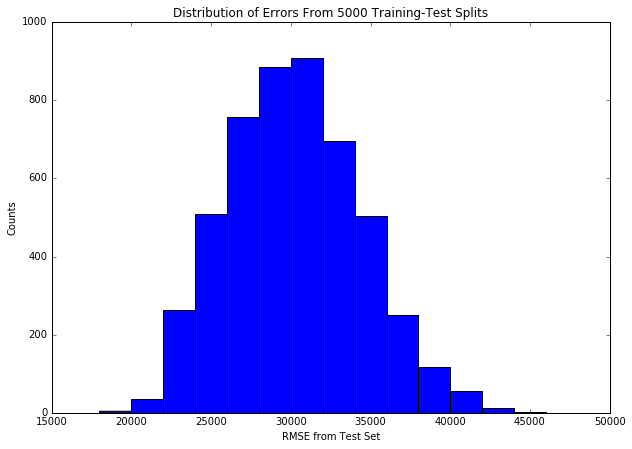

In [16]:
min_rmse_full = rmse_arr[len(rmse_arr)-1]
min_lt10k_full = lt_10k_arr[len(lt_10k_arr)-1]

print("RMSE from Full Data Set: {0}".format(min_rmse_full))
print("Maximum RMSE from Cross-Validation: {0}".format(max(scores)))

fig = plt.figure(figsize=(10,7))
bins = [x for x in range(18000,48000,2000)]
ax = fig.add_subplot(1,1,1)
ax.hist(scores, bins=bins)
ax.set_xlabel("RMSE from Test Set")
ax.set_ylabel("Counts")
ax.set_title("Distribution of Errors From 5000 Training-Test Splits")
plt.show()

**Discussion:** I performed cross-validation tests where the data was split 5 ways, and the model was trained using 4/5 parts and tested using 1/5 parts. Each split returned a RMSE value, so I could determine if the full dataset was causing overfitting (giving us lower error than each of the splits). To gather more statistics, I ran the cross-validation experiment 1000 times. The histogram above shows that our model is actually quite robust. Out of 5000 random splits that were tested, nearly all were centered around the RMSE value returned from the model that was applied to the entire data set. Only 1/5000 tests stood out, with an error of more than 115k. Thus, we should have a lot of confidence that our linear regression model is stable and will give us errors in line with what we've estimated.

**Comparison to Decision Trees**

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

n_vals = []
dtc_rmse = []
dtc_lt10k = []
dtr_rmse = []
dtr_lt10k = []

X = prices_num[reg_cols]
y = prices_num['SalePrice']

for n in range(2,200):
    n_vals.append(n)
    dtc = DecisionTreeClassifier(min_samples_leaf=n)
    dtr = DecisionTreeRegressor(min_samples_leaf=n)
    errors_dtc = reg_error(dtc, X, y)
    errors_dtr = reg_error(dtr, X, y)
    dtc_rmse.append(errors_dtc[0])
    dtc_lt10k.append(errors_dtc[1])
    dtr_rmse.append(errors_dtr[0])
    dtr_lt10k.append(errors_dtr[1])

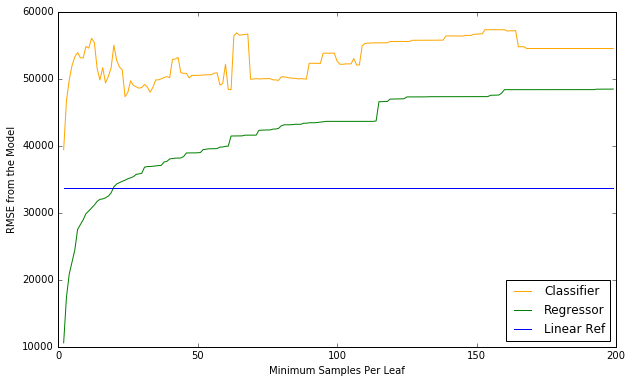

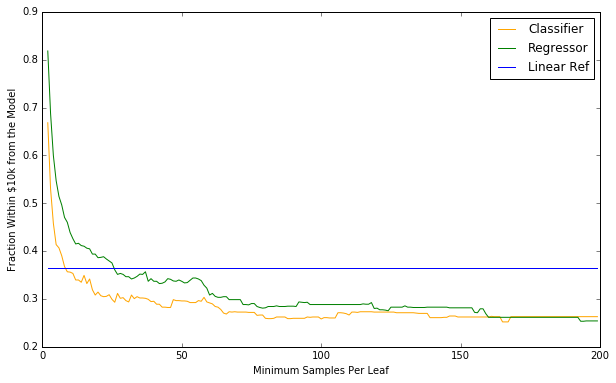

In [18]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(n_vals,dtc_rmse,label="Classifier",color="orange")
ax.plot(n_vals,dtr_rmse,label="Regressor",color="green")
ax.plot(n_vals,[min_rmse_full for n in n_vals],label="Linear Ref",color="blue")
ax.set_xlabel("Minimum Samples Per Leaf")
ax.set_ylabel("RMSE from the Model")
ax.legend(loc="lower right")
plt.show()

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(n_vals,dtc_lt10k,label="Classifier",color="orange")
ax.plot(n_vals,dtr_lt10k,label="Regressor",color="green")
ax.plot(n_vals,[min_lt10k_full for n in n_vals],label="Linear Ref",color="blue")
ax.set_xlabel("Minimum Samples Per Leaf")
ax.set_ylabel("Fraction Within $10k from the Model")
ax.legend(loc="upper right")
plt.show()

**Discussion:** I said I wasn't going to get into Decision Trees and other modelling techniques in this version, but I wanted to get a sense of how they might compare before we conclude. There are many knobs and dials that can be adjusted when building trees, but I only played with one: the minimum samples per leaf. You can see from the plots that when the trees are allowed to have very few samples per leaf, the accuracy skyrockets. But, it's artificial. The tree is being tuned to that dataset specifically, and if we did cross-validation, we'd see the accuracy plummet on test sets. Our dataset is large (1460 rows), but even having 20-30 samples per leaf (which means a LOT of leaves) still leads to larger errors than our linear regression model. That said, there may be a lot that can be tuned to improve performance. But, that will wait for another day!

**Conclusions:** In the end, I settled on a multi-variate linear regression model with 41 variables. More than half of those variables are dummy variables representing a single categorical variable: neighborhood. Based on the results from incrementally adding regression parameters, it's clear that location (neighborhood) is the best predictor of housing sale price. Overall quality of the house, number of bathrooms, lot size, and size of basement rounded out the top 5. The addition of the other variables led to marginal but noticeable improvements, so they were kept. Our final root mean squared error, based on cross-validation experiments, is ~\$30k, but more than 1/3 of our predictions are within \$10k of the actual price. 

Predictions
---

**Transforming the Test Data**

In [19]:
test = pd.read_csv("test.csv")

test_num, test_nb_cols = convert_df(test,"test")
min_index = len(prices_num) + 1
max_index = len(test_num) + min_index
test_num['Id'] = range(min_index,max_index)
test_num = test_num.set_index(keys=['Id'],drop=True)
test_num.index.name = None

test_num

,LotArea,OverallQual,OverallCond,YearBuilt,YearRemod,Baths,Bedrooms,Kitchens,Fireplaces,AveRmArea,...,in_NWAmes,in_NoRidge,in_NridgHt,in_OldTown,in_SWISU,in_Sawyer,in_SawyerW,in_Somerst,in_StoneBr,in_Timber
1461,11622,5,6,1961,0,1.0,2,1,0,179.200000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1462,14267,6,6,1958,0,1.5,3,1,0,221.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1463,13830,5,5,1997,1,2.5,3,1,1,271.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1464,9978,6,6,1998,0,2.5,3,1,1,229.142857,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1465,5005,8,5,1992,0,2.0,2,1,0,256.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1466,10000,6,5,1993,1,2.5,3,1,1,236.428571,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1467,7980,6,7,1992,15,3.0,3,1,0,197.833333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1468,8402,6,5,1998,0,2.5,3,1,1,209.285714,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1469,10176,7,5,1990,0,2.5,2,1,1,268.200000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1470,8400,4,5,1970,0,2.0,2,1,0,220.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
X_train = prices_num[reg_cols]
y_train = prices_num['SalePrice']
X_test = test_num[reg_cols]

lr.fit(X_train,y_train)
predictions = lr.predict(X_test)
test_num['SalePrice'] = predictions
test_num.to_csv("my_submission.csv",columns=['SalePrice'],index_label="Id")